In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
from datetime import datetime

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# Advanced Data Augmentations with reduced intensity for medical images
train_transform_low = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

train_transform_high = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)
    ], p=0.3),
    transforms.RandomAffine(degrees=5, translate=(0.03, 0.03), scale=(0.97, 1.03), shear=3),
    transforms.RandomHorizontalFlip(),
    # Removed vertical flip as it's anatomically incorrect for knee images
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.08), ratio=(0.3, 3.0))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor()
])

# Load datasets
data_dir = "knee"
class_names = sorted(os.listdir(os.path.join(data_dir, "train")))

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform_low)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_transform)

# Weighted sampler to address class imbalance with temperature parameter
class_counts = np.bincount([label for _, label in train_dataset])
temperature = 0.5  # Adjust this value to control the weighting strength
class_weights = 1. / (class_counts ** temperature)
class_weights = class_weights / class_weights.sum() * len(class_counts)
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [3]:
# SE block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# Model
class ImprovedKLClassifier(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.4):
        super().__init__()
        backbone = models.efficientnet_b0(pretrained=True)
        self.backbone = backbone.features
        self.se = SEBlock(1280)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.se(x)
        x = self.classifier(x)
        return x

model = ImprovedKLClassifier(num_classes=len(class_names)).to(device)


c:\uni\idp\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\uni\idp\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Focal Loss with adjusted parameters
class FocalLoss(nn.Module):
    def __init__(self, alpha=2, gamma=2.5):  # Increased alpha for more emphasis on hard examples
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


In [5]:
from torch.cuda.amp import GradScaler, autocast

def train_model(model, train_loader, val_loader, epochs=70, warmup_epochs=28, patience=20):
    scaler = GradScaler()
    best_val_loss = float('inf')
    early_stopping_counter = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} → Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Loss: {train_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_finaltest.pth")
            print("✅ Model saved.")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("⛔ Early stopping triggered.")
                break

        if epoch + 1 == warmup_epochs:
            print("Switching to high-resolution training...")
            train_loader.dataset.transform = train_transform_high

    return history

# Train model
history = train_model(model, train_loader, val_loader)


C:\Users\surya\AppData\Local\Temp\ipykernel_31132\2062952826.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\surya\AppData\Local\Temp\ipykernel_31132\2062952826.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/70 → Train Acc: 0.3060, Val Acc: 0.3620, Loss: 1.7357
✅ Model saved.
Epoch 2/70 → Train Acc: 0.4033, Val Acc: 0.4310, Loss: 1.3404
✅ Model saved.
Epoch 3/70 → Train Acc: 0.4462, Val Acc: 0.3680, Loss: 1.1504
Epoch 4/70 → Train Acc: 0.4855, Val Acc: 0.3789, Loss: 1.0061
Epoch 5/70 → Train Acc: 0.5317, Val Acc: 0.5230, Loss: 0.8814
✅ Model saved.
Epoch 6/70 → Train Acc: 0.5621, Val Acc: 0.5182, Loss: 0.8164
Epoch 7/70 → Train Acc: 0.5758, Val Acc: 0.5387, Loss: 0.7635
✅ Model saved.
Epoch 8/70 → Train Acc: 0.5916, Val Acc: 0.5012, Loss: 0.7167
Epoch 9/70 → Train Acc: 0.6071, Val Acc: 0.5097, Loss: 0.6807
Epoch 10/70 → Train Acc: 0.6115, Val Acc: 0.4988, Loss: 0.6615
Epoch 11/70 → Train Acc: 0.6244, Val Acc: 0.5061, Loss: 0.6480
Epoch 12/70 → Train Acc: 0.6329, Val Acc: 0.5496, Loss: 0.5993
✅ Model saved.
Epoch 13/70 → Train Acc: 0.6366, Val Acc: 0.4952, Loss: 0.5921
Epoch 14/70 → Train Acc: 0.6440, Val Acc: 0.5085, Loss: 0.5759
Epoch 15/70 → Train Acc: 0.6426, Val Acc: 0.5315, Lo

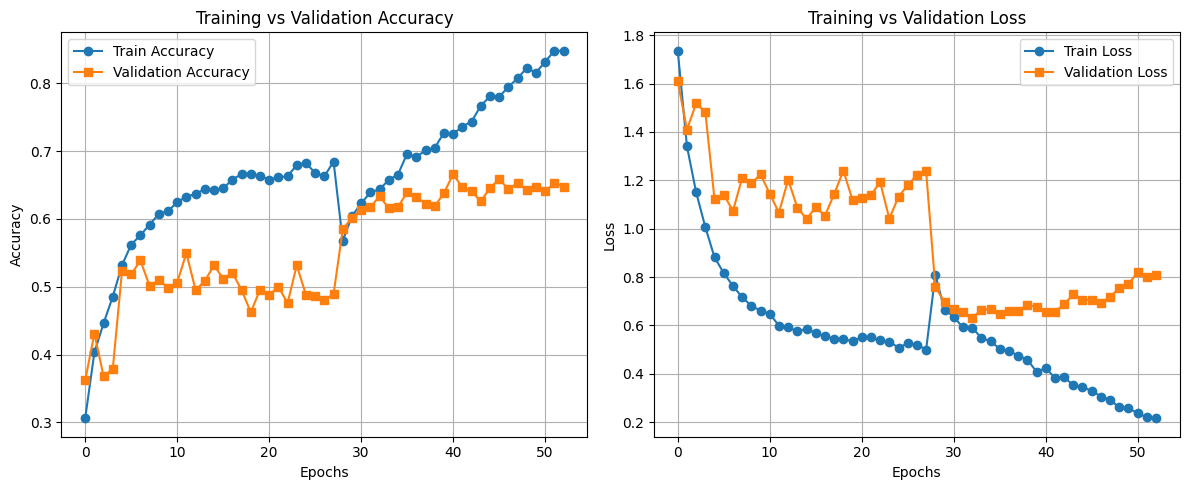

In [6]:
# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history["train_acc"], label="Train Accuracy", marker='o')
    plt.plot(history["val_acc"], label="Validation Accuracy", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history["train_loss"], label="Train Loss", marker='o')
    plt.plot(history["val_loss"], label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


C:\Users\surya\AppData\Local\Temp\ipykernel_31132\2976461589.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_finaltest.pth")

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       639
           1       0.32      0.20      0.25       296
           2       0.65      0.53      0.58       447
           3       0.73      0.80      0.76       223
           4       0.81      0.92      0.86        51

    accuracy                           0.65      1656
   macro avg       0.64      0.66      0.64      1656
weighted avg       0.62      0.65      0.62      1656



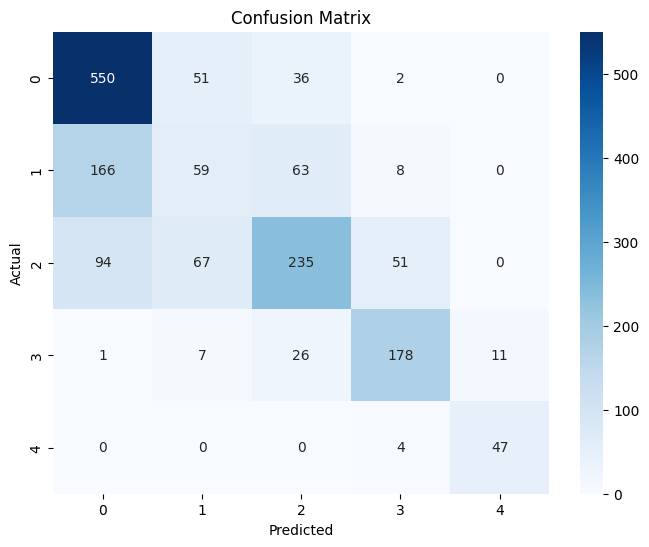

In [7]:
# Load best model
model.load_state_dict(torch.load("best_model_finaltest.pth"))
model.eval()

# Evaluate on test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


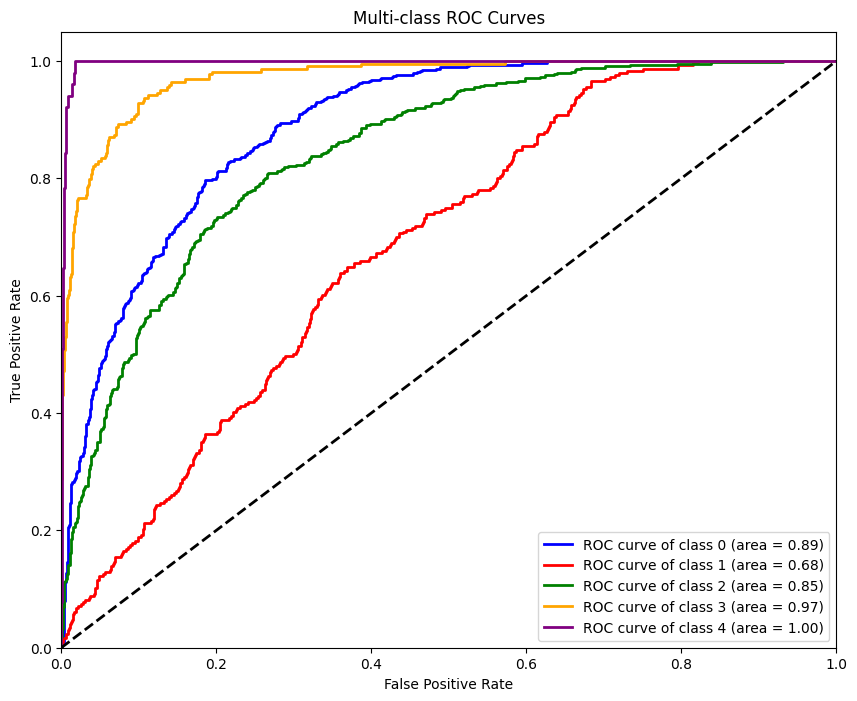

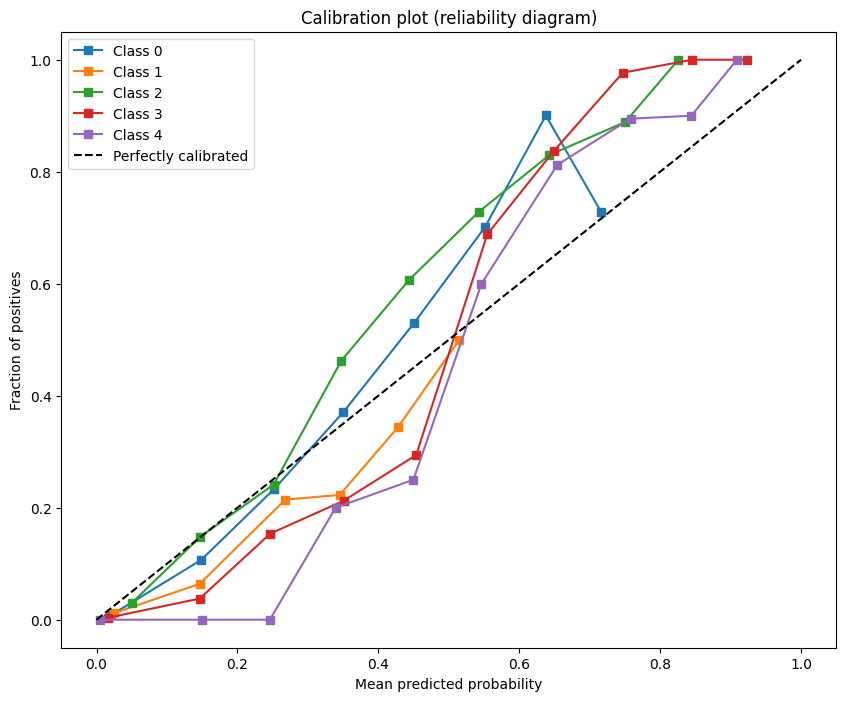

In [8]:
# Add comprehensive evaluation metrics
def plot_roc_curves(y_true, y_scores, class_names):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    
    for i in range(n_classes):
        y_true_binary = (np.array(y_true) == i).astype(int)
        y_score = y_scores[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

# Plot ROC curves
class_roc_auc = plot_roc_curves(all_labels, all_probs, class_names)

# Calculate calibration (reliability diagram)
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    y_true_binary = (all_labels == i).astype(int)
    y_prob = all_probs[:, i]
    
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true_binary, y_prob, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, 's-',
             label=f'Class {class_names[i]}')
    
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot (reliability diagram)')
plt.legend()
plt.show()


In [9]:
def test_time_augmentation(model, image, transform, num_augmentations=5):
    model.eval()
    images = [transform(image) for _ in range(num_augmentations)]
    images = torch.stack(images).to(device)
    
    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        avg_probs = probs.mean(dim=0)
        predicted_class = avg_probs.argmax().item()
        confidence = avg_probs[predicted_class].item()
    
    return predicted_class, confidence


🔍 Predicted KL Grade: 4 (Confidence: 85.05%)


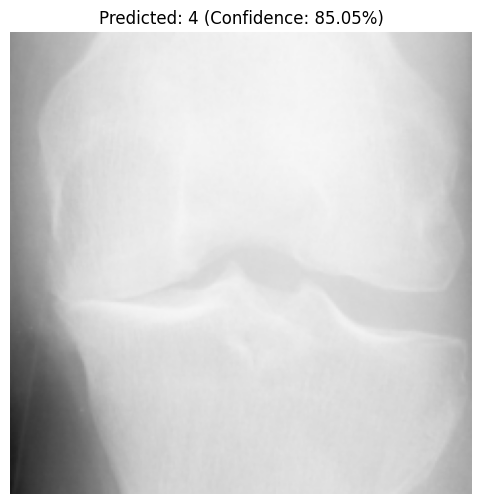

(4, 0.8504852652549744)

In [10]:
def predict_knee_grade(model, image_path, class_names, transform):
    try:
        image = Image.open(image_path).convert("RGB")
        predicted_class, confidence = test_time_augmentation(model, image, transform, num_augmentations=10)
        print(f"🔍 Predicted KL Grade: {class_names[predicted_class]} (Confidence: {confidence:.2%})")
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2%})")
        plt.axis('off')
        plt.show()
        return predicted_class, confidence
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None

# Example usage:
predict_knee_grade(model, "knee/val/4/9818359L.png", class_names, val_transform)


In [13]:
def predict_directory(model, directory_path, class_names, transform):
    results = []
    try:
        for filename in os.listdir(directory_path):
            if filename.endswith(".png") or filename.endswith(".jpg"):
                try:
                    image_path = os.path.join(directory_path, filename)
                    print(f"Predicting {filename}...")
                    image = Image.open(image_path).convert("RGB")
                    predicted_class, confidence = test_time_augmentation(model, image, transform, num_augmentations=5)
                    print(f"🔍 Predicted KL Grade: {class_names[predicted_class]} (Confidence: {confidence:.2%})")
                    results.append({
                        "filename": filename,
                        "predicted_class": predicted_class,
                        "predicted_label": class_names[predicted_class],
                        "confidence": confidence
                    })
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
        
        results_df = pd.DataFrame(results)
        return results_df
    except Exception as e:
        print(f"Error processing directory: {str(e)}")
        return pd.DataFrame()

# Example usage:
results_df = predict_directory(model, "knee/val/2", class_names, val_transform)
# results_df.to_csv("prediction_results.csv", index=False)


Predicting 9015402R.png...
🔍 Predicted KL Grade: 3 (Confidence: 49.20%)
Predicting 9023348R.png...
🔍 Predicted KL Grade: 2 (Confidence: 41.51%)
Predicting 9031141R.png...
🔍 Predicted KL Grade: 2 (Confidence: 33.71%)
Predicting 9031961L.png...
🔍 Predicted KL Grade: 1 (Confidence: 41.52%)
Predicting 9056978L.png...
🔍 Predicted KL Grade: 1 (Confidence: 40.49%)
Predicting 9067323R.png...
🔍 Predicted KL Grade: 2 (Confidence: 50.06%)
Predicting 9112020L.png...
🔍 Predicted KL Grade: 2 (Confidence: 54.60%)
Predicting 9112020R.png...
🔍 Predicted KL Grade: 3 (Confidence: 37.80%)
Predicting 9112495R.png...
🔍 Predicted KL Grade: 2 (Confidence: 47.55%)
Predicting 9113199L.png...
🔍 Predicted KL Grade: 2 (Confidence: 67.81%)
Predicting 9113199R.png...
🔍 Predicted KL Grade: 1 (Confidence: 46.11%)
Predicting 9118689L.png...
🔍 Predicted KL Grade: 1 (Confidence: 49.78%)
Predicting 9122517R.png...
🔍 Predicted KL Grade: 0 (Confidence: 35.69%)
Predicting 9122908R.png...
🔍 Predicted KL Grade: 2 (Confidence: 

In [12]:
# Save model version information
def save_model_info(model, all_labels, all_preds):
    model_info = {
        "model_name": "KneeOA_EfficientNet_B0",
        "version": "1.1.0",
        "accuracy": float(classification_report(all_labels, all_preds, output_dict=True)['accuracy']),
        "f1_macro": float(classification_report(all_labels, all_preds, output_dict=True)['macro avg']['f1-score']),
        "training_date": datetime.now().strftime("%Y-%m-%d"),
        "dependencies": {
            "torch": torch.__version__,
            "torchvision": torchvision.__version__,
            "numpy": np.__version__,
            "pandas": pd.__version__
        },
        "class_distribution": {
            class_name: int(np.sum(all_labels == i)) for i, class_name in enumerate(class_names)
        }
    }

    with open("model_info.json", "w") as f:
        json.dump(model_info, f, indent=4)

    print("✅ Model information saved to model_info.json")

# Example usage:
save_model_info(model, all_labels, all_preds)


NameError: name 'torchvision' is not defined